# Polymer Chemistry Informed Neural Networks (PCINNs)

**Paper:** Ballard, N. *Polymer Chemistry Informed Neural Networks.* *Polym. Chem.*, 2024. DOI: [10.1039/D4PY00995A](https://doi.org/10.1039/D4PY00995A)

**GitHub:** [PolymatGIQ/PCINN](https://github.com/PolymatGIQ/PCINN)

This notebook implements the PCINN method for predicting methyl methacrylate (MMA) free-radical polymerization outcomes. The approach combines a data-driven neural network with Jacobian-based regularization from a pretrained kinetic ("theory") model. The theory model provides gradient information that guides the trainable network toward physically consistent predictions, yielding improved generalization compared to a purely data-driven baseline.

In addition to the baseline NN and PCINN from the paper, this notebook includes a **Soft-Anchor PCINN** variant that adds a penalty term encouraging the trainable network's predictions to stay close to the theory model's outputs at randomly sampled points. This provides a complementary form of regularization alongside Jacobian matching.

The notebook has a fast single-fold workflow (`TestReaction`, default `8`) plus an optional full leave-one-experiment-out multi-seed section for paper-style aggregate evaluation.


In [1]:
# Install pinned dependencies (verified compatible as of February 2026).
# On systems with CUDA, follow https://pytorch.org/get-started/locally/
# to install the CUDA-enabled PyTorch build instead of the default CPU-only wheel.
# If a pin fails to resolve, check PyPI for the latest patch in the same minor
# series (e.g., numpy==2.4.3 if 2.4.2 is superseded).
%pip install torch==2.10.0 numpy==2.4.2 pandas==2.2.3 matplotlib==3.10.8 openpyxl==3.1.5 "ipykernel>=6.29,<7"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline

from __future__ import annotations

import os

# UNSAFE WORKAROUND — only enable if you hit OpenMP duplication errors.
# Can crash or silently produce incorrect results. Must be set before
# NumPy/PyTorch (and other heavy numeric libs) are imported in a fresh kernel.
ENABLE_UNSAFE_KMP_WORKAROUND = False

if ENABLE_UNSAFE_KMP_WORKAROUND:
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import copy
import json
import pickle
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.func import jacrev, vmap


## Reproducibility & Device

Seed all RNGs for reproducible results across runs. GPU is used when available.

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Optional strictness (may slow things down / error on nondeterministic ops):
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Model Definitions

Two neural network architectures are used. **`NNmodel`** is the trainable predictive network (5 inputs → 128 → 64 → 6 outputs, tanh activations) used for the baseline, PCINN, and Soft-Anchor PCINN experiments. **`DomainModel`** is the pretrained theory surrogate (5 → 128 → 128 → 64 with split output heads: sigmoid for conversion, softplus for log₁₀ molecular weights) that provides Jacobian targets during PCINN training. See paper Scheme 2 (theory model) and Scheme 3 (PCINN architecture).

**Important output semantics:** `DomainModel` returns `[sigmoid(X), softplus(log₁₀Mn), softplus(log₁₀Mw), softplus(log₁₀Mz), softplus(log₁₀Mz₊₁), softplus(log₁₀Mv)]`. The softplus ensures the log₁₀ values are positive (since M > 1 → log₁₀M > 0). These outputs are already in log-space for the molecular weight columns, NOT physical molecular weights.

In [4]:
class NNmodel(nn.Module):
    """Data-driven predictive network for MMA polymerization.

    Architecture: 5 → 128 → 64 → 6 (tanh activations).

    Inputs:  (batch, 5) — [M], [S], [I], temp, time  (all scaled 0–1)
    Outputs: (batch, 6) — X (conversion), log10(Mn), log10(Mw),
             log10(Mz), log10(Mz+1), log10(Mv)
    """

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class DomainModel(nn.Module):
    """Pretrained kinetic theory surrogate ("domain model").

    Architecture: 5 → 128 → 128 → 64 with split output heads.

    Inputs:  (batch, 5) — same as NNmodel
    Outputs: (batch, 6) — X via sigmoid ∈ [0, 1],
             Mn/Mw/Mz/Mz+1/Mv via softplus > 0  (physical units)
    """

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.Xout = nn.Linear(64, 1)
        self.Mout = nn.Linear(64, 5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        X_out = torch.sigmoid(self.Xout(x))      # conversion
        M_out = torch.nn.functional.softplus(self.Mout(x))  # Mn, Mw, Mz, Mz+1, Mv

        return torch.cat((X_out, M_out), dim=-1)

## Data Preprocessing

Input features are scaled to the [0, 1] range using precomputed per-feature min and max values stored in `scalerx_min.npy` and `scalerx_max.npy`. The five molecular weight outputs (Mn, Mw, Mz, Mz+1, Mv) are log10-transformed before training to reduce scale differences, while conversion (X) is left on its original scale.

In [5]:
def scalefeaturezeroone(
    x: np.ndarray,
    scalerxmax: np.ndarray,
    scalerxmin: np.ndarray,
    *,
    eps: float = 1e-12,
) -> np.ndarray:
    """Min-max scale features to [0, 1] with numerical safety."""
    denom = np.maximum(scalerxmax - scalerxmin, eps)
    return (x - scalerxmin) / denom

In [6]:
scalerx_max_np = np.load('scalerx_max.npy')
scalerx_min_np = np.load('scalerx_min.npy')

# Torch versions for use inside training loops (avoids NumPy/Torch interop warnings)
SCALERX_MAX = torch.from_numpy(scalerx_max_np).float().to(DEVICE)
SCALERX_MIN = torch.from_numpy(scalerx_min_np).float().to(DEVICE)
SCALERX_DENOM = torch.clamp(SCALERX_MAX - SCALERX_MIN, min=1e-12)

# Load training data
df = pd.read_excel('PMMAordered.xlsx')

dfX = df[["[M]", "[S]", "[I]", "temp", "time", "Reaction"]]
dfY = df[["X", "Mn", "Mw", "Mz", "Mzplus1", "Mv"]]

Xdata = dfX.values
Ydata = dfY.values

Ydata[:, 1:] = np.log10(Ydata[:, 1:])
Xdata[:, :5] = scalefeaturezeroone(Xdata[:, :5], scalerx_max_np, scalerx_min_np)

dfGPC = df.iloc[:, 18:]
GPCdata = dfGPC.values

# Load and freeze pretrained theory model
Domain_NN = DomainModel().to(DEVICE)

try:
    Domain_NN.load_state_dict(
        torch.load('MMA_solution_net.pt', weights_only=True, map_location=DEVICE)
    )
except pickle.UnpicklingError:
    Domain_NN.load_state_dict(
        torch.load('MMA_solution_net.pt', weights_only=False, map_location=DEVICE)
    )

Domain_NN.eval()
for p in Domain_NN.parameters():
    p.requires_grad_(False)

print(f"Domain_NN on {next(Domain_NN.parameters()).device}, eval={not Domain_NN.training}")
print(f"SCALERX_DENOM min={SCALERX_DENOM.min().item():.2e}")

Domain_NN on cpu, eval=True
SCALERX_DENOM min=9.50e-02


## Jacobian Sampling Configuration

During PCINN training, 32 random points are sampled per epoch from the physical domain to compute Jacobian matching loss. The sampling ranges correspond to experimentally relevant conditions: temperature 323–363 K (50–90 °C), monomer concentration [M] 0.5–5 mol/L, initiator concentration [I] 0.005–0.1 mol/L, and reaction time 300–36,000 s (5 min to 10 hours). See paper eqn (9) for the combined loss function.

In [7]:
Tupper = 273 + 90
Tlower = 273 + 50

Mupper = 5
Mlower = 0.5

Iupper = 0.1
Ilower = 0.005

timeupper = 10 * 60 * 60
timelower = 5 * 60

M_sampler = torch.distributions.Uniform(low=Mlower, high=Mupper)
T_sampler = torch.distributions.Uniform(low=Tlower, high=Tupper)
I_sampler = torch.distributions.Uniform(low=Ilower, high=Iupper)
time_sampler = torch.distributions.Uniform(low=timelower, high=timeupper)

## Training Configuration

A leave-one-experiment-out strategy is used throughout. In the single-fold training workflow, `TestReaction` selects which reaction is held out for testing while the remaining 7 reactions are used for training. The notebook default is `TestReaction = 8`.

For full leave-one-experiment-out evaluation across all 8 folds and multiple random seeds, use the dedicated **Full Leave-One-Experiment-Out Cross-Validation (Multi-Seed)** section later in the notebook. That section loops over folds 1 to 8 automatically and reports aggregate statistics.


In [8]:
TestReaction = 8  # Integer between 1 and 8. Picks reaction that will be tested on (other reactions for training)

# Convert train/test splits to tensors on DEVICE once (no repeated torch.from_numpy in loops)
Xtrainsample = torch.from_numpy(Xdata[Xdata[:, 5] != TestReaction, :5]).float().to(DEVICE)
Ytrainsample = torch.from_numpy(Ydata[Xdata[:, 5] != TestReaction]).float().to(DEVICE)

Xtestsample = torch.from_numpy(Xdata[Xdata[:, 5] == TestReaction, :5]).float().to(DEVICE)
Ytestsample = torch.from_numpy(Ydata[Xdata[:, 5] == TestReaction]).float().to(DEVICE)

print(f"Train: {Xtrainsample.shape}, Test: {Xtestsample.shape}, device={Xtrainsample.device}")

Train: torch.Size([49, 5]), Test: torch.Size([8, 5]), device=cpu


In [9]:
def safe_log(x: list[float], eps: float = 1e-12) -> np.ndarray:
    """Numerically safe natural log for loss curves (clamps near-zero values)."""
    arr = np.asarray(x, dtype=np.float64)
    return np.log(np.clip(arr, eps, None))

## Baseline Neural Network Training

This cell trains a conventional data-only neural network (no Jacobian regularization) as a control comparison. The model is trained for 10,000 epochs with Adam (lr=3e-4) and MSE loss on the training data only. This serves as the baseline against which the PCINN is compared in paper Table 3.

In [10]:
# [ORIGINAL — paper baseline, do not execute]
# Kept for reproducibility comparison. Use the improved cell below instead.

# model = NNmodel()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=3E-4)

# epochs = 10000
# reg_losses = []
# reg_losses_test = []
# for epoch in range(epochs):
#     Sum_Obj_loss = 0
#     pred = model(Xtrainsample)
#     trainloss = loss_function(pred, Ytrainsample)
#     Sum_Obj_loss += trainloss
#     if epoch >= 1:
#         trainloss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#     pred = model(Xtestsample)
#     testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
#     reg_losses.append(float(Sum_Obj_loss))
#     reg_losses_test.append(float(testloss))

# NNpred = model(Xtestsample)

# plt.plot(np.log(reg_losses), label='Training loss')
# plt.plot(np.log(reg_losses_test), label='Test loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

[Baseline] epoch=500/10000 train=0.128939 test=0.0339902
[Baseline] epoch=1000/10000 train=0.0151143 test=0.152319
[Baseline] epoch=1500/10000 train=0.00639641 test=0.162204
[Baseline] epoch=2000/10000 train=0.00427281 test=0.145994
[Baseline] epoch=2500/10000 train=0.00365353 test=0.138222
[Baseline] epoch=3000/10000 train=0.00325729 test=0.133477
[Baseline] epoch=3500/10000 train=0.00299282 test=0.12977
[Baseline] epoch=4000/10000 train=0.00272791 test=0.126875
[Baseline] epoch=4500/10000 train=0.00233491 test=0.124275
[Baseline] epoch=5000/10000 train=0.00193902 test=0.119328
[Baseline] epoch=5500/10000 train=0.00163401 test=0.111939
[Baseline] epoch=6000/10000 train=0.00144572 test=0.106284
[Baseline] epoch=6500/10000 train=0.00133776 test=0.105172
[Baseline] epoch=7000/10000 train=0.00124326 test=0.107492
[Baseline] epoch=7500/10000 train=0.00110907 test=0.111994
[Baseline] epoch=8000/10000 train=0.000943026 test=0.114756
[Baseline] epoch=8500/10000 train=0.000820066 test=0.118077

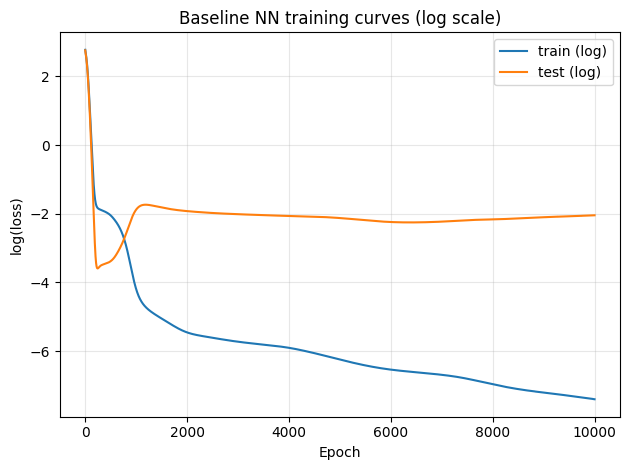

In [11]:
model = NNmodel().to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

EPOCHS = 10_000
train_losses: list[float] = []
test_losses: list[float] = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    pred = model(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)
    trainloss.backward()
    optimizer.step()

    train_losses.append(trainloss.item())

    model.eval()
    with torch.inference_mode():
        test_pred = model(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(f"[Baseline] epoch={epoch+1}/{EPOCHS} train={train_losses[-1]:.6g} test={test_losses[-1]:.6g}")

NNpred = model(Xtestsample)

plt.figure()
plt.plot(safe_log(train_losses), label="train (log)")
plt.plot(safe_log(test_losses), label="test (log)")
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.title("Baseline NN training curves (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## PCINN Training

The PCINN augments the standard data-driven MSE loss with a Jacobian matching term (see paper eqn 9). At each epoch, 32 random points are sampled from the physical domain and the Jacobian of both the trainable network and the pretrained theory network are computed using `vmap(jacrev(...))`. The MSE between these Jacobians is added to the data loss, encouraging the PCINN to learn input-output sensitivities consistent with the underlying kinetic model.

In [12]:
# [ORIGINAL — paper baseline, do not execute]
# Kept for reproducibility comparison. Use the improved cell below instead.

# PCINNmodel = NNmodel()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(PCINNmodel.parameters(), lr=3E-4)
#
# epochs = 10000
# reg_losses = []
# reg_losses_test = []
# totaljacsamples = 32
#
# for epoch in range(epochs):
#     Sum_Jac_loss = 0
#     Sum_Obj_loss = 0
#
#     pred = PCINNmodel(Xtrainsample)
#     trainloss = loss_function(pred, Ytrainsample)
#     Sum_Obj_loss += trainloss
#
#     Msample = M_sampler.sample((32, 1))
#     Ssample = 10 - Msample
#     Isample = I_sampler.sample((32, 1))
#     Tsample = T_sampler.sample((32, 1))
#     tsample = time_sampler.sample((32, 1))
#     sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), 1)
#     sampl = (sampl - scalerx_min) / (scalerx_max - scalerx_min)
#
#     jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl.float())
#     jac_sampl = vmap(jacrev(PCINNmodel))(sampl.float())
#
#     jacloss = loss_function(jac_sampl, jac_theory_sampl)
#     Sum_Jac_loss += jacloss
#
#     loss = trainloss + jacloss
#
#     if epoch >= 1:
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     reg_losses.append(float(Sum_Obj_loss))
#     pred = PCINNmodel(Xtestsample)
#     testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
#     reg_losses_test.append(float(testloss))
#
# EBNNpred = PCINNmodel(Xtestsample)
#
# plt.plot(np.log(reg_losses), label='Training loss')
# plt.plot(np.log(reg_losses_test), label='Test loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

[PCINN] epoch=500/10000 obj=0.0134359 jac=0.170443 test=0.0110015
[PCINN] epoch=1000/10000 obj=0.00705738 jac=0.268849 test=0.00518006
[PCINN] epoch=1500/10000 obj=0.00515545 jac=0.128008 test=0.00403267
[PCINN] epoch=2000/10000 obj=0.00448638 jac=0.106943 test=0.00481005
[PCINN] epoch=2500/10000 obj=0.00412373 jac=0.0659516 test=0.00371781
[PCINN] epoch=3000/10000 obj=0.00399458 jac=0.0256813 test=0.0040058
[PCINN] epoch=3500/10000 obj=0.00371204 jac=0.0324886 test=0.0041484
[PCINN] epoch=4000/10000 obj=0.00369781 jac=0.0197388 test=0.00421294
[PCINN] epoch=4500/10000 obj=0.00366691 jac=0.0660086 test=0.00386596
[PCINN] epoch=5000/10000 obj=0.00375705 jac=0.061766 test=0.0045834
[PCINN] epoch=5500/10000 obj=0.00376378 jac=0.028492 test=0.00416363
[PCINN] epoch=6000/10000 obj=0.00356935 jac=0.0196464 test=0.00467277
[PCINN] epoch=6500/10000 obj=0.00342411 jac=0.0233459 test=0.00438553
[PCINN] epoch=7000/10000 obj=0.00344349 jac=0.0368499 test=0.00461301
[PCINN] epoch=7500/10000 obj=0.0

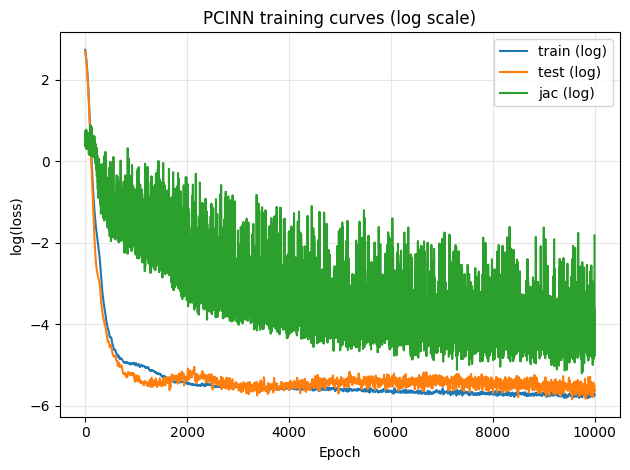

In [13]:
PCINNmodel = NNmodel().to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(PCINNmodel.parameters(), lr=3e-4)

EPOCHS = 10_000
TOTAL_JAC_SAMPLES = 32

pcinn_train_losses: list[float] = []
pcinn_test_losses: list[float] = []
jac_losses: list[float] = []

for epoch in range(EPOCHS):
    PCINNmodel.train()
    optimizer.zero_grad(set_to_none=True)

    pred = PCINNmodel(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)

    # --- Jacobian sampling ---
    Msample = M_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Ssample = 10 - Msample
    Isample = I_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Tsample = T_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    tsample = time_sampler.sample((TOTAL_JAC_SAMPLES, 1))

    sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), dim=1).to(DEVICE)
    sampl = (sampl - SCALERX_MIN) / SCALERX_DENOM

    # Ensure sampl is a leaf tensor that can be differentiated
    sampl = sampl.float().detach().requires_grad_(True)

    # Theory Jacobian: grad enabled (needed for jacrev) but params frozen; detach as target
    jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl).detach()
    # PCINN Jacobian: requires grad so jacloss backprops into PCINN params
    jac_sampl = vmap(jacrev(PCINNmodel))(sampl)

    jacloss = loss_function(jac_sampl, jac_theory_sampl)

    loss = trainloss + jacloss
    loss.backward()
    optimizer.step()

    pcinn_train_losses.append(trainloss.item())
    jac_losses.append(jacloss.item())

    PCINNmodel.eval()
    with torch.inference_mode():
        test_pred = PCINNmodel(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    pcinn_test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(
            f"[PCINN] epoch={epoch+1}/{EPOCHS} "
            f"obj={pcinn_train_losses[-1]:.6g} jac={jac_losses[-1]:.6g} test={pcinn_test_losses[-1]:.6g}"
        )

EBNNpred = PCINNmodel(Xtestsample)

plt.figure()
plt.plot(safe_log(pcinn_train_losses), label="train (log)")
plt.plot(safe_log(pcinn_test_losses), label="test (log)")
plt.plot(safe_log(jac_losses), label="jac (log)")
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.title("PCINN training curves (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Soft-Anchor PCINN

An experimental variant that adds a **soft anchor** loss term to the standard PCINN training objective. At each epoch, random points are sampled from the physical domain (the same points used for Jacobian matching), and an MSE penalty encourages the trainable network's output predictions to stay close to the pretrained theory model's outputs at those points.

The combined loss function is:

$$L = L_{\text{data}} + L_{\text{jac}} + \lambda_{\text{anchor}} \cdot L_{\text{anchor}}$$

where $L_{\text{anchor}} = \text{MSE}(y_{\text{net}}(x_j),\; y_{\text{theory}}(x_j))$ over the same randomly sampled $x_j$ used for Jacobian matching.

**Rationale:** The standard PCINN uses Jacobian matching to constrain the *trends* (derivatives) of the network, but imposes no constraint on the *values*. The soft anchor adds a gentle bias toward the theory model's predictions without structurally locking the network to them (as a residual-correction architecture would). This means the network can still deviate from theory wherever the training data demands, but in unexplored regions of input space it defaults toward physically reasonable predictions. The anchor weight $\lambda_{\text{anchor}}$ controls the strength of this bias: too high and the network cannot correct theory errors at the training points; too low and it provides no regularization benefit.

Unlike a residual-correction architecture (which I tried first, which forces $y = \text{theory} + \delta$ structurally), the soft anchor is a loss-level constraint that does not interfere with Jacobian matching. The Jacobian matching loss constrains $\partial y/\partial x$ while the anchor constrains $y$ itself: these are complementary and non-conflicting objectives.

Soft-Anchor PCINN params: 9,414
Anchor weight: 0.05
[SA-PCINN] epoch=500/10000 data=0.0133198 jac=0.304361 anchor=0.192581 test=0.0147755
[SA-PCINN] epoch=1000/10000 data=0.00671775 jac=0.357115 anchor=0.138212 test=0.00421478
[SA-PCINN] epoch=1500/10000 data=0.00590768 jac=0.0720835 anchor=0.105767 test=0.00314604
[SA-PCINN] epoch=2000/10000 data=0.00517493 jac=0.0618769 anchor=0.1102 test=0.0030965
[SA-PCINN] epoch=2500/10000 data=0.00441847 jac=0.0442181 anchor=0.081077 test=0.00269584
[SA-PCINN] epoch=3000/10000 data=0.00399471 jac=0.0450019 anchor=0.0743968 test=0.00272977
[SA-PCINN] epoch=3500/10000 data=0.00382708 jac=0.034657 anchor=0.0749936 test=0.00276663
[SA-PCINN] epoch=4000/10000 data=0.00381416 jac=0.038819 anchor=0.0764253 test=0.00259164
[SA-PCINN] epoch=4500/10000 data=0.00367474 jac=0.0364204 anchor=0.0741534 test=0.00269195
[SA-PCINN] epoch=5000/10000 data=0.00359759 jac=0.0237039 anchor=0.073535 test=0.00295458
[SA-PCINN] epoch=5500/10000 data=0.00365183 jac=0.0107

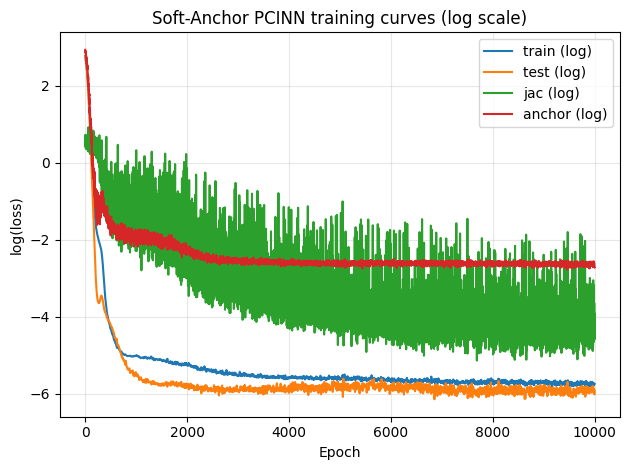

In [15]:
ANCHOR_WEIGHT = 0.05  # Strength of the soft anchor toward theory predictions

SAPCINNmodel = NNmodel().to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(SAPCINNmodel.parameters(), lr=3e-4)

EPOCHS = 10_000
TOTAL_JAC_SAMPLES = 32

sa_train_losses: list[float] = []
sa_test_losses: list[float] = []
sa_jac_losses: list[float] = []
sa_anchor_losses: list[float] = []

print(f"Soft-Anchor PCINN params: {sum(p.numel() for p in SAPCINNmodel.parameters()):,}")
print(f"Anchor weight: {ANCHOR_WEIGHT}")

for epoch in range(EPOCHS):
    SAPCINNmodel.train()
    optimizer.zero_grad(set_to_none=True)

    # Data loss (identical to standard PCINN)
    pred = SAPCINNmodel(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)

    # --- Jacobian + anchor sampling (same random points for both) ---
    Msample = M_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Ssample = 10 - Msample
    Isample = I_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Tsample = T_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    tsample = time_sampler.sample((TOTAL_JAC_SAMPLES, 1))

    sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), dim=1).to(DEVICE)
    sampl = (sampl - SCALERX_MIN) / SCALERX_DENOM
    sampl = sampl.float().detach().requires_grad_(True)

    # Jacobian matching (same as standard PCINN)
    jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl).detach()
    jac_sampl = vmap(jacrev(SAPCINNmodel))(sampl)
    jacloss = loss_function(jac_sampl, jac_theory_sampl)

    # Soft anchor: penalize deviation from theory model's predictions
    # Domain_NN outputs [X, log10(Mn), ...] — same space as SAPCINNmodel
    with torch.no_grad():
        theory_pred = Domain_NN(sampl)
    anchor_pred = SAPCINNmodel(sampl)
    anchorloss = loss_function(anchor_pred, theory_pred)

    loss = trainloss + jacloss + ANCHOR_WEIGHT * anchorloss
    loss.backward()
    optimizer.step()

    sa_train_losses.append(trainloss.item())
    sa_jac_losses.append(jacloss.item())
    sa_anchor_losses.append(anchorloss.item())

    SAPCINNmodel.eval()
    with torch.inference_mode():
        test_pred = SAPCINNmodel(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    sa_test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(
            f"[SA-PCINN] epoch={epoch+1}/{EPOCHS} "
            f"data={sa_train_losses[-1]:.6g} jac={sa_jac_losses[-1]:.6g} "
            f"anchor={sa_anchor_losses[-1]:.6g} test={sa_test_losses[-1]:.6g}"
        )

SApred = SAPCINNmodel(Xtestsample)

plt.figure()
plt.plot(safe_log(sa_train_losses), label="train (log)")
plt.plot(safe_log(sa_test_losses), label="test (log)")
plt.plot(safe_log(sa_jac_losses), label="jac (log)")
plt.plot(safe_log(sa_anchor_losses), label="anchor (log)")
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.title("Soft-Anchor PCINN training curves (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Results Summary

This section compares train/test loss curves for the three single-fold models (Baseline NN, PCINN, SA-PCINN) and prints final test losses for the currently selected held-out reaction (`TestReaction`).

Use this as the quick-iteration summary. For paper-style aggregate performance across all folds and seeds, run the optional long-running multi-seed cross-validation section below.


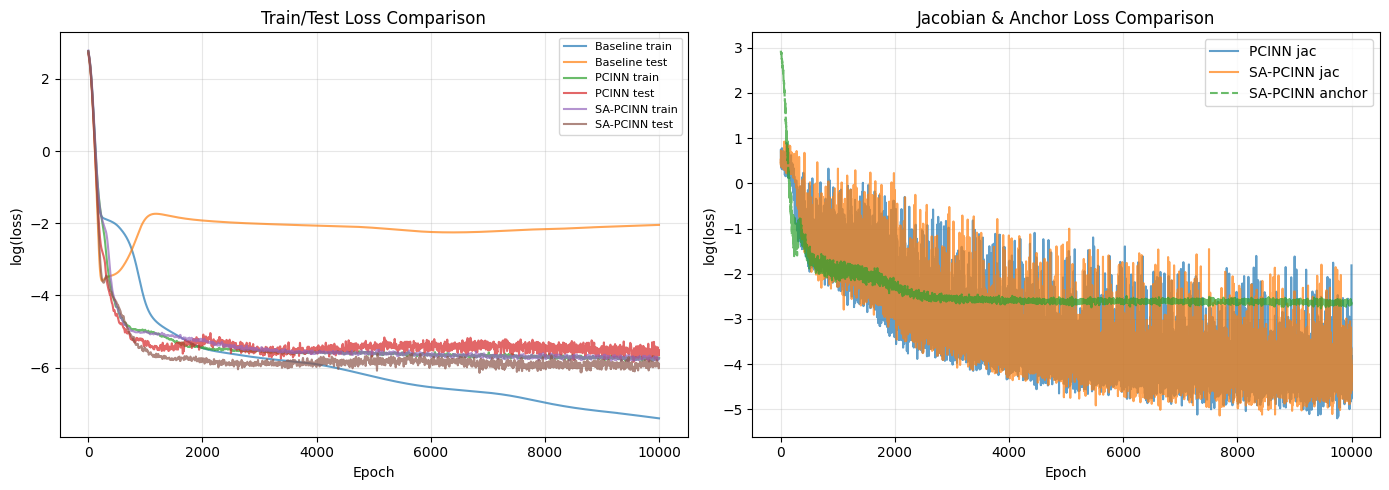


Final test losses:
  Baseline NN:    0.129292
  PCINN:          0.00403127
  SA-PCINN:       0.00268379


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: train + test loss for all three models
axes[0].plot(safe_log(train_losses), label="Baseline train", alpha=0.7)
axes[0].plot(safe_log(test_losses), label="Baseline test", alpha=0.7)
axes[0].plot(safe_log(pcinn_train_losses), label="PCINN train", alpha=0.7)
axes[0].plot(safe_log(pcinn_test_losses), label="PCINN test", alpha=0.7)
axes[0].plot(safe_log(sa_train_losses), label="SA-PCINN train", alpha=0.7)
axes[0].plot(safe_log(sa_test_losses), label="SA-PCINN test", alpha=0.7)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("log(loss)")
axes[0].set_title("Train/Test Loss Comparison")
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=8)

# Right: Jacobian + anchor losses
axes[1].plot(safe_log(jac_losses), label="PCINN jac", alpha=0.7)
axes[1].plot(safe_log(sa_jac_losses), label="SA-PCINN jac", alpha=0.7)
axes[1].plot(safe_log(sa_anchor_losses), label="SA-PCINN anchor", alpha=0.7, linestyle="--")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("log(loss)")
axes[1].set_title("Jacobian & Anchor Loss Comparison")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nFinal test losses:")
print(f"  Baseline NN:    {test_losses[-1]:.6g}")
print(f"  PCINN:          {pcinn_test_losses[-1]:.6g}")
print(f"  SA-PCINN:       {sa_test_losses[-1]:.6g}")

# Full Leave-One-Experiment-Out Cross-Validation (Multi-Seed)

This section is optional and long-running.

It reproduces the full evaluation protocol from Ballard et al. (Polym. Chem., 2024) with Table-4-style reporting: per-output average MSE across all 8 folds for the kinetic model, Baseline NN, PCINN, and Soft-Anchor PCINN.

Each fold is trained with `N_SEEDS` different random seeds to separate architectural effects from seed-dependent variance. Results are reported as mean +/- std across fold-seed runs.

Total learned-model runs: `3 architectures x 8 folds x N_SEEDS`.


Full 8-fold CV × 5 seeds = 120 training runs
Seeds: [42, 123, 256, 789, 1337]

──────────────────────────────────────────────────────────────────────
Fold 1/8 — holding out R1 (train=52, test=5)
──────────────────────────────────────────────────────────────────────
  seed=  42  NN=0.009472  PCINN=0.002223  SA=0.002754  [3/120]
  seed= 123  NN=0.009854  PCINN=0.002452  SA=0.002592  [6/120]
  seed= 256  NN=0.007192  PCINN=0.002013  SA=0.002698  [9/120]
  seed= 789  NN=0.003912  PCINN=0.002274  SA=0.002669  [12/120]
  seed=1337  NN=0.005181  PCINN=0.002269  SA=0.001973  [15/120]

──────────────────────────────────────────────────────────────────────
Fold 2/8 — holding out R2 (train=50, test=7)
──────────────────────────────────────────────────────────────────────
  seed=  42  NN=0.019592  PCINN=0.009008  SA=0.010241  [18/120]
  seed= 123  NN=0.024190  PCINN=0.007963  SA=0.008570  [21/120]
  seed= 256  NN=0.024303  PCINN=0.010714  SA=0.012112  [24/120]
  seed= 789  NN=0.005126  PCINN=0.008

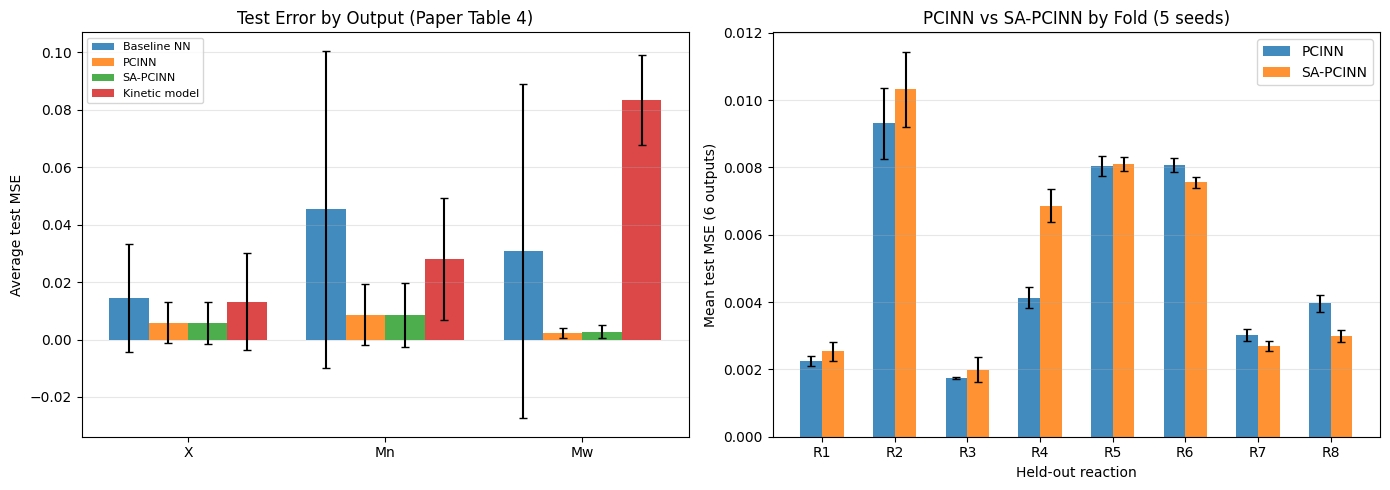

In [19]:
N_SEEDS = 5  # Number of random seeds per fold per model
BASE_SEEDS = [42, 123, 256, 789, 1337][:N_SEEDS]  # Deterministic seed list


def train_baseline_nn(
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    x_test: torch.Tensor,
    y_test: torch.Tensor,
    *,
    epochs: int = 10_000,
    lr: float = 3e-4,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Train a standard data-only NNmodel and return (train_pred, test_pred).

    Parameters
    ----------
    x_train : torch.Tensor
        Training inputs, shape (N_train, 5), scaled 0–1, on DEVICE.
    y_train : torch.Tensor
        Training targets, shape (N_train, 6), [X, log10(Mn), ...], on DEVICE.
    x_test : torch.Tensor
        Test inputs, shape (N_test, 5), on DEVICE.
    y_test : torch.Tensor
        Test targets, shape (N_test, 6), on DEVICE.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate for Adam optimizer.

    Returns
    -------
    train_pred : torch.Tensor
        Predictions on training set, shape (N_train, 6).
    test_pred : torch.Tensor
        Predictions on test set, shape (N_test, 6).
    """
    net = NNmodel().to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        net.train()
        opt.zero_grad(set_to_none=True)
        loss = loss_fn(net(x_train), y_train)
        loss.backward()
        opt.step()

    net.eval()
    with torch.inference_mode():
        return net(x_train), net(x_test)


def train_pcinn(
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    x_test: torch.Tensor,
    y_test: torch.Tensor,
    *,
    epochs: int = 10_000,
    lr: float = 3e-4,
    n_jac_samples: int = 32,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Train a PCINN (data + Jacobian matching) and return (train_pred, test_pred).

    Parameters
    ----------
    x_train : torch.Tensor
        Training inputs, shape (N_train, 5), scaled 0–1, on DEVICE.
    y_train : torch.Tensor
        Training targets, shape (N_train, 6), on DEVICE.
    x_test : torch.Tensor
        Test inputs, shape (N_test, 5), on DEVICE.
    y_test : torch.Tensor
        Test targets, shape (N_test, 6), on DEVICE.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate for Adam optimizer.
    n_jac_samples : int
        Number of random Jacobian sample points per epoch.

    Returns
    -------
    train_pred : torch.Tensor
        Predictions on training set, shape (N_train, 6).
    test_pred : torch.Tensor
        Predictions on test set, shape (N_test, 6).
    """
    net = NNmodel().to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        net.train()
        opt.zero_grad(set_to_none=True)

        trainloss = loss_fn(net(x_train), y_train)

        Msamp = M_sampler.sample((n_jac_samples, 1))
        Ssamp = 10 - Msamp
        Isamp = I_sampler.sample((n_jac_samples, 1))
        Tsamp = T_sampler.sample((n_jac_samples, 1))
        tsamp = time_sampler.sample((n_jac_samples, 1))
        sampl = torch.cat((Msamp, Ssamp, Isamp, Tsamp, tsamp), dim=1).to(DEVICE)
        sampl = ((sampl - SCALERX_MIN) / SCALERX_DENOM).float().detach().requires_grad_(True)

        jac_theory = vmap(jacrev(Domain_NN))(sampl).detach()
        jac_net = vmap(jacrev(net))(sampl)
        jacloss = loss_fn(jac_net, jac_theory)

        (trainloss + jacloss).backward()
        opt.step()

    net.eval()
    with torch.inference_mode():
        return net(x_train), net(x_test)


def train_sa_pcinn(
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    x_test: torch.Tensor,
    y_test: torch.Tensor,
    *,
    epochs: int = 10_000,
    lr: float = 3e-4,
    n_jac_samples: int = 32,
    anchor_weight: float = 0.05,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Train a Soft-Anchor PCINN and return (train_pred, test_pred).

    Same as PCINN but with an additional MSE penalty encouraging
    the network's predictions to stay close to Domain_NN's outputs
    at the randomly sampled Jacobian points.

    Parameters
    ----------
    x_train : torch.Tensor
        Training inputs, shape (N_train, 5), scaled 0–1, on DEVICE.
    y_train : torch.Tensor
        Training targets, shape (N_train, 6), on DEVICE.
    x_test : torch.Tensor
        Test inputs, shape (N_test, 5), on DEVICE.
    y_test : torch.Tensor
        Test targets, shape (N_test, 6), on DEVICE.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate for Adam optimizer.
    n_jac_samples : int
        Number of random Jacobian/anchor sample points per epoch.
    anchor_weight : float
        Weight for the soft anchor loss term.

    Returns
    -------
    train_pred : torch.Tensor
        Predictions on training set, shape (N_train, 6).
    test_pred : torch.Tensor
        Predictions on test set, shape (N_test, 6).
    """
    net = NNmodel().to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        net.train()
        opt.zero_grad(set_to_none=True)

        trainloss = loss_fn(net(x_train), y_train)

        Msamp = M_sampler.sample((n_jac_samples, 1))
        Ssamp = 10 - Msamp
        Isamp = I_sampler.sample((n_jac_samples, 1))
        Tsamp = T_sampler.sample((n_jac_samples, 1))
        tsamp = time_sampler.sample((n_jac_samples, 1))
        sampl = torch.cat((Msamp, Ssamp, Isamp, Tsamp, tsamp), dim=1).to(DEVICE)
        sampl = ((sampl - SCALERX_MIN) / SCALERX_DENOM).float().detach().requires_grad_(True)

        jac_theory = vmap(jacrev(Domain_NN))(sampl).detach()
        jac_net = vmap(jacrev(net))(sampl)
        jacloss = loss_fn(jac_net, jac_theory)

        with torch.no_grad():
            theory_pred = Domain_NN(sampl)
        anchorloss = loss_fn(net(sampl), theory_pred)

        (trainloss + jacloss + anchor_weight * anchorloss).backward()
        opt.step()

    net.eval()
    with torch.inference_mode():
        return net(x_train), net(x_test)


def per_output_mse(pred: torch.Tensor, target: torch.Tensor) -> dict[str, float]:
    """Compute MSE for each output column individually.

    Parameters
    ----------
    pred : torch.Tensor
        Predictions, shape (N, 6).
    target : torch.Tensor
        Targets, shape (N, 6).

    Returns
    -------
    dict[str, float]
        MSE for each of the 6 output columns, keyed by output name.
    """
    names = ["X", "Mn", "Mw", "Mz", "Mz+1", "Mv"]
    diff_sq = (pred - target) ** 2
    return {name: diff_sq[:, i].mean().item() for i, name in enumerate(names)}


# ── Run the full multi-seed 8-fold cross-validation ──────────────────────────

OUTPUT_NAMES = ["X", "Mn", "Mw", "Mz", "Mz+1", "Mv"]
MODEL_NAMES = ["Baseline NN", "PCINN", "SA-PCINN"]

# Training function dispatch table
TRAIN_FNS = {
    "Baseline NN": train_baseline_nn,
    "PCINN": train_pcinn,
    "SA-PCINN": train_sa_pcinn,
}

# Storage: results[model][split][col] = list of MSE values (one per fold×seed)
# Each list will have N_SEEDS * 8 entries.
results: dict[str, dict[str, dict[str, list[float]]]] = {}
for m in MODEL_NAMES + ["Kinetic model"]:
    results[m] = {
        "train": {c: [] for c in OUTPUT_NAMES},
        "test":  {c: [] for c in OUTPUT_NAMES},
    }

# Per-fold-seed storage for the head-to-head comparison:
# fold_results[model][fold_idx] = list of N_SEEDS mean-6-output test MSE values
fold_results: dict[str, list[list[float]]] = {m: [[] for _ in range(8)] for m in MODEL_NAMES}

total_runs = len(MODEL_NAMES) * 8 * N_SEEDS
run_count = 0

print("=" * 70)
print(f"Full 8-fold CV × {N_SEEDS} seeds = {total_runs} training runs")
print(f"Seeds: {BASE_SEEDS}")
print("=" * 70)

for fold in range(1, 9):
    # Build train/test splits for this fold
    x_tr = torch.from_numpy(Xdata[Xdata[:, 5] != fold, :5]).float().to(DEVICE)
    y_tr = torch.from_numpy(Ydata[Xdata[:, 5] != fold]).float().to(DEVICE)
    x_te = torch.from_numpy(Xdata[Xdata[:, 5] == fold, :5]).float().to(DEVICE)
    y_te = torch.from_numpy(Ydata[Xdata[:, 5] == fold]).float().to(DEVICE)

    # Kinetic model — deterministic, only compute once per fold
    Domain_NN.eval()
    with torch.inference_mode():
        km_train_pred = Domain_NN(x_tr)
        km_test_pred = Domain_NN(x_te)
    for split, pred, tgt in [("train", km_train_pred, y_tr), ("test", km_test_pred, y_te)]:
        mse = per_output_mse(pred, tgt)
        for c in OUTPUT_NAMES:
            # Replicate N_SEEDS times so averaging works uniformly
            results["Kinetic model"][split][c].extend([mse[c]] * N_SEEDS)

    print(f"\n{'─' * 70}")
    print(f"Fold {fold}/8 — holding out R{fold} (train={x_tr.shape[0]}, test={x_te.shape[0]})")
    print(f"{'─' * 70}")

    for seed_idx, seed_val in enumerate(BASE_SEEDS):
        # Combine base seed with fold for a unique but deterministic seed
        run_seed = seed_val * 10 + fold

        for model_name in MODEL_NAMES:
            run_count += 1
            torch.manual_seed(run_seed)

            train_fn = TRAIN_FNS[model_name]
            tr_pred, te_pred = train_fn(x_tr, y_tr, x_te, y_te)

            tr_mse = per_output_mse(tr_pred, y_tr)
            te_mse = per_output_mse(te_pred, y_te)

            for c in OUTPUT_NAMES:
                results[model_name]["train"][c].append(tr_mse[c])
                results[model_name]["test"][c].append(te_mse[c])

            # Mean across 6 outputs for fold-level head-to-head
            mean_te = sum(te_mse[c] for c in OUTPUT_NAMES) / len(OUTPUT_NAMES)
            fold_results[model_name][fold - 1].append(mean_te)

        # Progress line for this fold×seed
        pc_te = fold_results["PCINN"][fold - 1][-1]
        sa_te = fold_results["SA-PCINN"][fold - 1][-1]
        nn_te = fold_results["Baseline NN"][fold - 1][-1]
        print(
            f"  seed={seed_val:4d}  "
            f"NN={nn_te:.6f}  PCINN={pc_te:.6f}  SA={sa_te:.6f}  "
            f"[{run_count}/{total_runs}]"
        )


# ── Compute statistics across all folds and seeds ────────────────────────────

# avg[model][split][col] = (mean, std) across all fold×seed entries
avg: dict[str, dict[str, dict[str, tuple[float, float]]]] = {}
for m in results:
    avg[m] = {}
    for split in ["train", "test"]:
        avg[m][split] = {}
        for c in OUTPUT_NAMES:
            vals = np.array(results[m][split][c])
            avg[m][split][c] = (float(vals.mean()), float(vals.std()))


# ── Print Table 4–style results with uncertainty ─────────────────────────────

print("\n\n")
print("=" * 90)
print(f"Table 4 Comparison — Average MSE across 8 folds × {N_SEEDS} seeds (mean ± std)")
print("(Paper-comparable: X, Mn, Mw)")
print("=" * 90)

header_cols = ["X", "Mn", "Mw"]

print(f"\n{'':20s}  {'Training error':^36s}  {'Test error':^36s}")
print(f"{'':20s}  {'X':>11s} {'Mn':>11s} {'Mw':>11s}  {'X':>11s} {'Mn':>11s} {'Mw':>11s}")
print("─" * 96)

for model_name in ["Baseline NN", "PCINN", "SA-PCINN", "Kinetic model"]:
    if model_name == "Kinetic model":
        train_str = f"{'—':>11s} {'—':>11s} {'—':>11s}"
    else:
        parts = []
        for c in header_cols:
            m, s = avg[model_name]["train"][c]
            parts.append(f"{m:.3f}±{s:.3f}")
        train_str = " ".join(f"{p:>11s}" for p in parts)

    test_parts = []
    for c in header_cols:
        m, s = avg[model_name]["test"][c]
        test_parts.append(f"{m:.3f}±{s:.3f}")
    test_str = " ".join(f"{p:>11s}" for p in test_parts)

    print(f"{model_name:20s}  {train_str}  {test_str}")

print()

# Extended table: all 6 outputs, test error only
print("=" * 90)
print("Extended Table — All 6 outputs, test error (mean ± std)")
print("=" * 90)

print(f"\n{'':20s}", end="")
for c in OUTPUT_NAMES:
    print(f" {c:>12s}", end="")
print(f"  {'Mean':>12s}")
print("─" * 102)

for model_name in ["Baseline NN", "PCINN", "SA-PCINN", "Kinetic model"]:
    vals_mean = [avg[model_name]["test"][c][0] for c in OUTPUT_NAMES]
    vals_std  = [avg[model_name]["test"][c][1] for c in OUTPUT_NAMES]
    overall_mean = sum(vals_mean) / len(vals_mean)
    overall_std = (sum(s**2 for s in vals_std) / len(vals_std)) ** 0.5  # RMS of stds

    print(f"{model_name:20s}", end="")
    for m, s in zip(vals_mean, vals_std):
        print(f" {m:5.4f}±{s:.3f}", end="")
    print(f"  {overall_mean:5.4f}±{overall_std:.3f}")


# ── Per-fold head-to-head with confidence ────────────────────────────────────

print("\n\n")
print("=" * 90)
print("Per-fold comparison: PCINN vs SA-PCINN (mean ± std of 6-output test MSE)")
print("=" * 90)

sa_wins_mean = 0
sa_wins_all_seeds = 0

for f in range(8):
    pc_vals = np.array(fold_results["PCINN"][f])
    sa_vals = np.array(fold_results["SA-PCINN"][f])

    pc_mean, pc_std = pc_vals.mean(), pc_vals.std()
    sa_mean, sa_std = sa_vals.mean(), sa_vals.std()

    # Paired comparison: for each seed, did SA beat PCINN?
    sa_seed_wins = int((sa_vals < pc_vals).sum())

    delta_pct = (sa_mean - pc_mean) / pc_mean * 100
    if sa_mean < pc_mean:
        sa_wins_mean += 1
        marker = "✓ SA wins on mean"
    else:
        marker = "✗ PCINN wins on mean"

    sa_wins_all_seeds += sa_seed_wins

    print(
        f"  R{f+1}: PCINN={pc_mean:.5f}±{pc_std:.5f}  "
        f"SA={sa_mean:.5f}±{sa_std:.5f}  "
        f"({delta_pct:+.1f}%)  "
        f"SA wins {sa_seed_wins}/{N_SEEDS} seeds  "
        f"{marker}"
    )

total_comparisons = 8 * N_SEEDS
print(f"\nSA-PCINN wins {sa_wins_mean}/8 folds (by mean)")
print(f"SA-PCINN wins {sa_wins_all_seeds}/{total_comparisons} individual seed×fold matchups")


# ── Visualization ────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Table 4 bar chart with error bars
bar_cols = ["X", "Mn", "Mw"]
all_models = ["Baseline NN", "PCINN", "SA-PCINN", "Kinetic model"]
x_pos = np.arange(len(bar_cols))
width = 0.2

for i, model_name in enumerate(all_models):
    means = [avg[model_name]["test"][c][0] for c in bar_cols]
    stds  = [avg[model_name]["test"][c][1] for c in bar_cols]
    axes[0].bar(
        x_pos + i * width, means, width,
        yerr=stds, capsize=3, label=model_name, alpha=0.85,
    )

axes[0].set_xticks(x_pos + 1.5 * width)
axes[0].set_xticklabels(bar_cols)
axes[0].set_ylabel("Average test MSE")
axes[0].set_title("Test Error by Output (Paper Table 4)")
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3, axis="y")

# Right: per-fold PCINN vs SA-PCINN with error bars
folds_x = np.arange(8)
pc_means = [np.mean(fold_results["PCINN"][f]) for f in range(8)]
pc_stds  = [np.std(fold_results["PCINN"][f]) for f in range(8)]
sa_means = [np.mean(fold_results["SA-PCINN"][f]) for f in range(8)]
sa_stds  = [np.std(fold_results["SA-PCINN"][f]) for f in range(8)]

axes[1].bar(
    folds_x - 0.15, pc_means, 0.3,
    yerr=pc_stds, capsize=3, label="PCINN", alpha=0.85,
)
axes[1].bar(
    folds_x + 0.15, sa_means, 0.3,
    yerr=sa_stds, capsize=3, label="SA-PCINN", alpha=0.85,
)
axes[1].set_xticks(folds_x)
axes[1].set_xticklabels([f"R{f+1}" for f in range(8)])
axes[1].set_xlabel("Held-out reaction")
axes[1].set_ylabel("Mean test MSE (6 outputs)")
axes[1].set_title(f"PCINN vs SA-PCINN by Fold ({N_SEEDS} seeds)")
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Multi-Seed Cross-Validation Results

The full leave-one-experiment-out cross-validation was run with 5 different random seeds per fold per model, yielding 120 total training runs (3 architectures × 8 folds × 5 seeds). This controls for the sensitivity of neural network training to weight initialization, which is substantial in this low-data regime (~50 training points per fold). Reporting mean ± standard deviation across seeds allows us to distinguish genuine architectural effects from seed-dependent noise.

### Comparison with Paper Table 4

The overall averages closely reproduce the trends reported in Ballard et al. (2024) Table 4. The baseline NN overfits severely (low training error, high test error), the PCINN substantially improves generalization through Jacobian matching, and the kinetic model shows systematic deviations — particularly on Mw, where its test MSE (0.083) is an order of magnitude worse than the PCINN's (0.002). Minor numerical differences from the published table are expected due to differences in random seed state, the epoch-0 skip bug fix in the improved training loop, and the newer PyTorch version (2.10.0 vs 2.0.1).

### PCINN vs Soft-Anchor PCINN

On aggregate, the two methods are nearly indistinguishable: the PCINN achieves a mean 6-output test MSE of 0.0051 ± 0.007, while the SA-PCINN achieves 0.0054 ± 0.007. However, the per-fold breakdown reveals a systematic pattern that is more informative than the averages suggest.

The SA-PCINN wins on folds 6, 7, and 8 with perfect seed-level consistency (5/5 seeds on each fold), achieving improvements of 6.5%, 10.8%, and 24.5% respectively. It loses on folds 1–5, most dramatically on fold 4 where it is 66% worse. The overall seed×fold record is exactly 20/40, a clean 50/50 split: but this is not noise, because the wins and losses cluster perfectly by fold rather than being randomly distributed across seeds.

### Why the Anchor Helps on Some Folds and Hurts on Others

The reactions where SA-PCINN wins (R6, R7, R8) share a common property: they sit at the high end of the temperature range (70–80 °C) with diverse monomer and initiator loadings. When these reactions are held out, the remaining 7 training reactions still provide reasonable coverage of the surrounding input space, and the kinetic model's predictions at the test conditions are qualitatively reasonable even if quantitatively imperfect. In this regime, the soft anchor provides a useful bias: in unexplored regions of input space, the network defaults toward the theory model's predictions rather than extrapolating freely, and this turns out to be a better prior than no constraint at all.

Conversely, fold 4 (R4: 70 °C, 10.3 g monomer, 0.9 g initiator) is the case where the SA-PCINN struggles most. R4 has the lowest monomer loading combined with high initiator concentration: a regime where the kinetic model's simplifying assumptions (constant termination rate coefficient, no gel effect) are likely least accurate. Here, the anchor actively harms generalization because it pulls the network toward systematically wrong theory predictions at the test conditions. The standard PCINN avoids this problem because Jacobian matching constrains the network's *trends* (derivatives) without anchoring its *values* to the theory's output, allowing it to deviate from theory wherever the training data demands.

### Practical Implications

These results suggest a practical guideline: the soft anchor is most beneficial when the kinetic model is trusted to be qualitatively correct across the full experimental range, and least beneficial when certain reaction regimes push beyond the model's validity envelope. For well-studied polymerization systems where the kinetic model's functional form is known to be reliable (even if its rate coefficients are imprecise), the SA-PCINN's value-level regularization can provide a meaningful improvement. For novel chemistries or regimes where the theory model's assumptions may break down, the standard PCINN's derivative-only regularization is the safer choice, as it inherits the theory's trends without being committed to its specific predictions.


## Model Export

Exports the three single-fold models trained above for the current `TestReaction` (default `8`): `baseline_nn`, `pcinn`, and `sa_pcinn`.

The cell selects the best model by final single-fold test loss, saves per-model weights/bundles/metadata in `exports/`, and copies the best weights/bundle to `best_fold{fold}_*` convenience files. A smoke-test reload verifies identical predictions (`max_diff < 1e-6`).

This export step is independent of the full multi-seed CV section and does not export every CV run.


In [20]:
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

fold = int(TestReaction)

# ── Identify the best model by final test loss ────────────────────────────

candidates: dict[str, tuple[nn.Module, float]] = {
    "baseline_nn": (model, test_losses[-1]),
    "pcinn":       (PCINNmodel, pcinn_test_losses[-1]),
    "sa_pcinn":    (SAPCINNmodel, sa_test_losses[-1]),
}

print(f"Final test losses (TestReaction={fold}):")
for name, (_, loss) in candidates.items():
    print(f"  {name:15s}: {loss:.6g}")

best_name = min(candidates, key=lambda k: candidates[k][1])
best_model, best_loss = candidates[best_name]
print(f"\nBest model: {best_name} (test loss = {best_loss:.6g})")

# ── Export all three models ───────────────────────────────────────────────

for name, (net, loss) in candidates.items():
    net.eval()

    weights_path = EXPORT_DIR / f"{name}_fold{fold}_weights.pt"
    bundle_path = EXPORT_DIR / f"{name}_fold{fold}_bundle.pt"
    meta_path = EXPORT_DIR / f"{name}_fold{fold}_meta.json"

    # 1) Weights only
    torch.save(net.state_dict(), weights_path)

    # 2) Full inference bundle (weights + scaling params + metadata)
    bundle = {
        "model_class": "NNmodel",
        "model_name": name,
        "model_state_dict": copy.deepcopy(net.state_dict()),
        "scalerx_min": scalerx_min_np,
        "scalerx_max": scalerx_max_np,
        "y_log10_applied_to_columns_1_to_end": True,
        "fold": fold,
        "final_test_loss": loss,
        "is_best": (name == best_name),
        "pytorch_version": torch.__version__,
    }
    torch.save(bundle, bundle_path)

    # 3) Human-readable JSON metadata
    meta: dict = {
        "architecture": "NNmodel",
        "training_method": name,
        "fold": fold,
        "epochs": 10_000,
        "lr": 3e-4,
        "total_jac_samples": 32 if name != "baseline_nn" else 0,
        "final_test_loss": loss,
        "is_best": (name == best_name),
        "pytorch_version": torch.__version__,
    }
    if name == "sa_pcinn":
        meta["anchor_weight"] = ANCHOR_WEIGHT
    meta_path.write_text(json.dumps(meta, indent=2))

    # 4) Smoke-test reload
    reloaded = NNmodel().to(DEVICE)
    reloaded.load_state_dict(
        torch.load(weights_path, weights_only=True, map_location=DEVICE)
    )
    reloaded.eval()

    with torch.inference_mode():
        a = net(Xtestsample)
        b = reloaded(Xtestsample)
    max_diff = (a - b).abs().max().item()
    assert max_diff < 1e-6, f"Reload mismatch for {name}: max diff={max_diff}"

    best_marker = " ← BEST" if name == best_name else ""
    print(f"\n[{name}] Saved & verified (reload max diff = {max_diff:.2e}){best_marker}")
    print(f"  - {weights_path}")
    print(f"  - {bundle_path}")
    print(f"  - {meta_path}")

# ── Symlink / copy best model for easy access ─────────────────────────────

best_weights_src = EXPORT_DIR / f"{best_name}_fold{fold}_weights.pt"
best_weights_dst = EXPORT_DIR / f"best_fold{fold}_weights.pt"
best_bundle_src = EXPORT_DIR / f"{best_name}_fold{fold}_bundle.pt"
best_bundle_dst = EXPORT_DIR / f"best_fold{fold}_bundle.pt"

import shutil
shutil.copy2(best_weights_src, best_weights_dst)
shutil.copy2(best_bundle_src, best_bundle_dst)

print(f"\nBest model ({best_name}) also copied to:")
print(f"  - {best_weights_dst}")
print(f"  - {best_bundle_dst}")

Final test losses (TestReaction=8):
  baseline_nn    : 0.129292
  pcinn          : 0.00403127
  sa_pcinn       : 0.00268379

Best model: sa_pcinn (test loss = 0.00268379)

[baseline_nn] Saved & verified (reload max diff = 0.00e+00)
  - exports\baseline_nn_fold8_weights.pt
  - exports\baseline_nn_fold8_bundle.pt
  - exports\baseline_nn_fold8_meta.json

[pcinn] Saved & verified (reload max diff = 0.00e+00)
  - exports\pcinn_fold8_weights.pt
  - exports\pcinn_fold8_bundle.pt
  - exports\pcinn_fold8_meta.json

[sa_pcinn] Saved & verified (reload max diff = 0.00e+00) ← BEST
  - exports\sa_pcinn_fold8_weights.pt
  - exports\sa_pcinn_fold8_bundle.pt
  - exports\sa_pcinn_fold8_meta.json

Best model (sa_pcinn) also copied to:
  - exports\best_fold8_weights.pt
  - exports\best_fold8_bundle.pt
